In [1]:
from google.colab import drive
drive.mount('/content/drive')

rawdata_path = '/content/drive/MyDrive/my_project/my_project1/rawdata'
data_path = '/content/drive/MyDrive/my_project/my_project1/data'
final_result = '/content/drive/MyDrive/my_project/my_project1/result/reg(인구)'
final_img = '/content/drive/MyDrive/my_project/my_project1/result/img'
final_sang = '/content/drive/MyDrive/my_project/my_project1/result/sang'
# rawdata_path = 'rawdata/'
# data_path = 'data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# # 1. 나눔 폰트 다운
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [48]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

import geopandas as gpd

import statsmodels.api as sm
import re
from io import StringIO

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [4]:
year_list = ['2022', '2023', '2024']

for year in year_list:
    globals()[f'temp_{year}'] = pd.read_csv(f'{data_path}/final/final_{year}.csv')

    globals()[f'temp_{year}'][f'solo_20s_{year}'] = globals()[f'temp_{year}'].apply(lambda x: (x[f'solo_20_{year}'] + x[f'solo_25_{year}']) / 2, axis = 1)
    globals()[f'temp_{year}'][f'solo_30s_{year}'] = globals()[f'temp_{year}'].apply(lambda x: (x[f'solo_30_{year}'] + x[f'solo_35_{year}']) / 2, axis = 1)

    globals()[f'temp_{year}'][f'solo_all_ratio'] = globals()[f'temp_{year}'].apply(lambda x: x[f'solo_all_{year}'] / x[f'total_all_{year}'] * 100, axis=1)
    globals()[f'temp_{year}'][f'solo_20s_ratio'] = globals()[f'temp_{year}'].apply(lambda x: x[f'solo_20s_{year}'] / x[f'solo_all_{year}'] * 100, axis=1)
    globals()[f'temp_{year}'][f'solo_30s_ratio'] = globals()[f'temp_{year}'].apply(lambda x: x[f'solo_30s_{year}'] / x[f'solo_all_{year}'] * 100, axis=1)
    globals()[f'temp_{year}'] = globals()[f'temp_{year}'].replace('-', '0')


In [5]:
depend_list = ['solo_all_ratio', 'solo_20s_ratio', 'solo_30s_ratio']
depend_name = ['all', '20', '30']

In [6]:
var_col = ['네일숍', '미용실', '애완동물',
           '분식전문점', '한식음식점', '양식음식점', '일식음식점', '중식음식점', '치킨전문점',
           '커피-음료', '패스트푸드점', '제과점', '호프-간이주점',
            '대형마트', '쇼핑업체수', '편의점', '슈퍼마켓'
           ]

nocal_col = ['사업체수', '종사자수', '지가변동률', '지가', '대학교', '기타대학' ]

drop_col = [ '면적', '월평균소득', '총상주인구', '20대상주인구', '총직장인구', '20대직장인구', '유통업체수',]

reg_col = ['ADM_CD'] + depend_list + var_col + nocal_col

In [7]:
df_2022 = temp_2022.copy()
columns_2022 = [col.replace('_2022', '') for col in df_2022.columns]
columns_2023 = [col.replace('_2023', '') for col in columns_2022]
columns_2024 = [col.replace('_2024', '') for col in columns_2023]
df_2022.columns = columns_2024


In [8]:
reg_2022 = df_2022[reg_col + ['total_all']]
for var in var_col:
        reg_2022[var] = reg_2022[var] / reg_2022['total_all'] * 100

reg_2022.drop(columns = 'total_all', inplace=True)
reg_2022

,ADM_CD,solo_all_ratio,solo_20s_ratio,solo_30s_ratio,네일숍,미용실,애완동물,분식전문점,한식음식점,양식음식점,...,대형마트,쇼핑업체수,편의점,슈퍼마켓,사업체수,종사자수,지가변동률,지가,대학교,기타대학
0,11010530,23.623853,10.868393,12.108954,0.165647,0.382263,0.127421,1.618247,5.262487,2.331804,...,0.0,0.000000,0.140163,0.000000,4994,56046,4.858500,96.517917,0.0,0.0
1,11010540,34.857383,10.108303,11.371841,0.041946,0.000000,0.000000,0.713087,3.062081,3.565436,...,0.0,0.000000,0.083893,0.000000,970,5118,4.673571,96.461429,0.0,0.0
2,11010550,16.783677,11.601307,10.947712,0.000000,0.109697,0.065818,0.153576,0.449759,0.405880,...,0.0,0.000000,0.032909,0.000000,908,4140,5.295000,96.764000,1.0,0.0
3,11010560,10.436593,8.073566,8.135910,0.013013,0.104106,0.019520,0.097599,0.364370,0.123625,...,0.0,0.000000,0.019520,0.000000,1286,4294,5.151000,96.442000,0.0,0.0
4,11030740,28.773407,11.130908,15.041260,0.059360,0.248233,0.075549,0.145702,1.063083,1.133236,...,0.0,0.000000,0.059360,0.016189,3213,20440,6.127000,95.366000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,11010600,28.133635,8.928571,12.142857,0.000000,0.200955,0.025119,0.527506,1.682994,1.105250,...,0.0,0.000000,0.075358,0.000000,977,15449,4.457000,96.575000,0.0,0.0
418,11010610,49.126157,12.002990,8.505232,0.161551,0.514026,0.161551,3.524747,17.227199,4.640916,...,0.0,0.102805,0.455280,0.014686,17095,106826,4.757000,96.444172,1.0,0.0
419,11220630,13.926386,11.276252,12.665590,0.238481,1.021418,0.265479,0.463463,2.362311,0.472462,...,0.0,0.004500,0.292477,0.004500,2720,16795,6.174000,95.269000,0.0,0.0
420,11090700,24.407020,12.764194,9.997928,0.262985,1.562737,0.308501,0.566429,3.307541,0.151722,...,0.0,0.000000,0.257927,0.000000,2297,7190,4.930000,97.841000,0.0,1.0


In [9]:
df_2023 = temp_2023.copy()
columns_2022 = [col.replace('_2022', '') for col in df_2023.columns]
columns_2023 = [col.replace('_2023', '') for col in columns_2022]
columns_2024 = [col.replace('_2024', '') for col in columns_2023]
df_2023.columns = columns_2024

In [10]:
reg_2023 = df_2023[reg_col + ['total_all']]
for var in var_col:
        reg_2023[var] = reg_2023[var] / reg_2023['total_all'] * 100

reg_2023.drop(columns = 'total_all', inplace=True)
reg_2023

,ADM_CD,solo_all_ratio,solo_20s_ratio,solo_30s_ratio,네일숍,미용실,애완동물,분식전문점,한식음식점,양식음식점,...,대형마트,쇼핑업체수,편의점,슈퍼마켓,사업체수,종사자수,지가변동률,지가,대학교,기타대학
0,11010530,23.824092,11.048689,12.092028,0.165711,0.407903,0.101976,1.580625,5.277247,2.319949,...,0.0,0.000000,0.140217,0.000000,4994,56046,7.902167,98.973167,0.0,0.0
1,11010540,33.755274,9.562500,11.437500,0.084388,0.000000,0.000000,0.717300,3.080169,3.586498,...,0.0,0.000000,0.042194,0.000000,970,5118,7.840571,99.057857,0.0,0.0
2,11010550,16.992102,11.846352,10.942544,0.000000,0.109697,0.076788,0.153576,0.416849,0.405880,...,0.0,0.000000,0.043879,0.000000,908,4140,8.004000,98.822000,1.0,0.0
3,11010560,10.521179,8.008658,8.163265,0.013013,0.104106,0.019520,0.091092,0.357863,0.117119,...,0.0,0.000000,0.019520,0.000000,1286,4294,8.009000,98.655000,0.0,0.0
4,11030740,28.781888,11.149793,14.904027,0.064995,0.249147,0.064995,0.140822,1.094080,1.175324,...,0.0,0.000000,0.059579,0.016249,3213,20440,10.155000,98.676000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,11010600,28.862095,9.442994,12.358573,0.000000,0.200955,0.025119,0.502386,1.682994,1.105250,...,0.0,0.000000,0.100477,0.000000,977,15449,7.389000,98.986000,0.0,0.0
418,11010610,51.245969,12.514302,8.195080,0.146585,0.498388,0.190560,3.488713,17.487540,4.632073,...,0.0,0.102609,0.498388,0.014658,17095,106826,7.914103,99.068069,1.0,0.0
419,11220630,14.020878,11.360719,12.885109,0.247480,1.052916,0.283477,0.418467,2.303816,0.530958,...,0.0,0.004500,0.310475,0.004500,2720,16795,10.086000,98.672000,0.0,0.0
420,11090700,23.520569,13.645079,10.161909,0.275593,1.543318,0.345743,0.536153,3.161798,0.130280,...,0.0,0.000000,0.255549,0.000000,2297,7190,7.019000,99.601000,0.0,1.0


In [11]:
df_2024 = temp_2024.copy()
columns_2022 = [col.replace('_2022', '') for col in df_2024.columns]
columns_2023 = [col.replace('_2023', '') for col in columns_2022]
columns_2024 = [col.replace('_2024', '') for col in columns_2023]
df_2024.columns = columns_2024

In [12]:
reg_2024 = df_2024[reg_col  + ['total_all']]
for var in var_col:
        reg_2024[var] = reg_2024[var] / reg_2024['total_all'] * 100

reg_2024.drop(columns = 'total_all', inplace=True)
reg_2024

,ADM_CD,solo_all_ratio,solo_20s_ratio,solo_30s_ratio,네일숍,미용실,애완동물,분식전문점,한식음식점,양식음식점,...,대형마트,쇼핑업체수,편의점,슈퍼마켓,사업체수,종사자수,지가변동률,지가,대학교,기타대학
0,11010530,24.625028,9.863636,11.022727,0.156705,0.391762,0.111932,1.365570,4.555630,2.093127,...,0.0,0.000000,0.134318,0.000000,4994,56046,8.764667,100.182750,0.0,0.0
1,11010540,35.323769,13.172338,9.659715,0.038775,0.000000,0.038775,0.659170,2.946879,3.295851,...,0.0,0.000000,0.038775,0.000000,970,5118,8.613000,100.133714,0.0,0.0
2,11010550,17.147193,11.536030,10.335019,0.000000,0.108389,0.086711,0.140906,0.390202,0.411879,...,0.0,0.000000,0.043356,0.000000,908,4140,9.032000,100.209000,1.0,0.0
3,11010560,10.506159,7.867558,7.594168,0.019149,0.095743,0.025531,0.082977,0.338291,0.127657,...,0.0,0.000000,0.025531,0.000000,1286,4294,9.204000,100.254000,0.0,0.0
4,11030740,28.631568,10.882193,14.204030,0.072761,0.249467,0.067564,0.124734,1.034250,1.226547,...,0.0,0.000000,0.057170,0.015592,3213,20440,11.399000,100.192000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,11010600,29.180084,8.870968,12.011885,0.000000,0.198167,0.024771,0.470647,1.659648,1.065147,...,0.0,0.000000,0.099083,0.000000,977,15449,8.215000,100.184000,0.0,0.0
418,11010610,48.905192,11.020078,9.381491,0.135440,0.361174,0.225734,2.652370,13.758465,3.611738,...,0.0,0.079007,0.327314,0.011287,17095,106826,8.712793,100.158517,1.0,0.0
419,11220630,13.962063,10.738148,12.281260,0.270979,1.021723,0.270979,0.377593,2.327751,0.524188,...,0.0,0.004442,0.310959,0.004442,2720,16795,11.430000,100.170000,0.0,0.0
420,11090700,25.509848,12.617279,9.470289,0.309150,1.515831,0.363999,0.463725,2.996759,0.114685,...,0.0,0.000000,0.289205,0.000000,2297,7190,7.376000,100.144000,0.0,1.0


# 상권

- 20대 : <br>
(+) 네일숍, 대학교, 편의점 <br>
(-) 애완동물, 제과점 <br>

<br>

- 30대 : <br>
(+) 일식음식점, 네일숍, 편의점 <br>
(-) 치킨전문점, 제과점, 분식전문점 <br>


### 필요한 컬럼

행정동, 점포수, 매출, 유동인구, 거주인구, 1인 가구 비율

인구분석 -- 거주인구 /  생활인구 / 직장인구 <br>
입지분석 -- 지형지세, 집객시설, 주요건출물, 점포정보, 대중교통분석 <br>
상권분석 -- 주요업종, 생존률 분석 <br>

In [116]:
dong_info = ['ADM_CD', 'total_all', 'solo_20s_ratio',	'solo_30s_ratio']
basic_info = ['월평균소득', '총상주인구', '20대상주인구',  '30대상주인구', '총직장인구', '20대직장인구', '30대직장인구']
cvs = [col for col in df_2023.columns if '편의점' in col]
nail = [col for col in df_2023.columns if '네일숍' in col]
bake = [col for col in df_2023.columns if '제과점' in col]

selected_col = dong_info + basic_info  + cvs + nail + bake

In [117]:
shop_list = ['cvs', 'nail', 'bake']
shopname_list = ['편의점', '네일숍', '제과점']

In [133]:
df_ols = pd.DataFrame()
for idx, shop in enumerate(shop_list):
    reg_temp = df_2023[dong_info + basic_info  + globals()[shop]]
    reg_temp.drop(columns = ['ADM_CD',  '총상주인구','총직장인구',
                             f'20대매출건수_{shopname_list[idx]}', f'20대매출금액_{shopname_list[idx]}', f'30대매출건수_{shopname_list[idx]}', f'30대매출금액_{shopname_list[idx]}', f'{shopname_list[idx]}'], inplace = True)

    std_scaler = StandardScaler()
    df_std = std_scaler.fit_transform(reg_temp)
    df_std = pd.DataFrame(df_std)
    df_std.columns = reg_temp.columns

    depend_list = [f'총매출금액_{shopname_list[idx]}', f'총매출건수_{shopname_list[idx]}']

    for depend in depend_list:
        X = sm.add_constant(df_std.drop(columns = depend_list))

        # Fit the OLS model
        model = sm.OLS(df_std[depend], X)
        result = model.fit()

        summary = result.summary()

        temp = summary.tables[1].as_csv()

        ols_result = pd.read_csv(StringIO(temp), skipinitialspace=True)
        ols_result.columns = ['var', 'coef', 'std', 't', 'p', 'confi25', 'conf97']
        ols_result = ols_result[['var', 'coef', 'p']]

        ols_result['p'] = ols_result['p'].apply(lambda x: '+' if x < 0.05 else ' ')
        ols_result['coef'] = ols_result['coef'].apply(lambda x: round(x, 3))
        ols_result.columns = [f'var', f'c_{shopname_list[idx]}_{depend}', f'p_{shopname_list[idx]}_{depend}']
        ols_result['var'] = ols_result['var'].str.strip()

        globals()[f'{shop}_{depend}'] = ols_result

        if (idx == 0) & (depend == f'총매출금액_{shopname_list[idx]}'):
            df_ols = ols_result
        else:
            df_ols = df_ols.merge(ols_result,
                                        how = 'left',
                                        on = 'var')


In [134]:
df_ols

,var,c_편의점_총매출금액_편의점,p_편의점_총매출금액_편의점,c_편의점_총매출건수_편의점,p_편의점_총매출건수_편의점,c_네일숍_총매출금액_네일숍,p_네일숍_총매출금액_네일숍,c_네일숍_총매출건수_네일숍,p_네일숍_총매출건수_네일숍,c_제과점_총매출금액_제과점,p_제과점_총매출금액_제과점,c_제과점_총매출건수_제과점,p_제과점_총매출건수_제과점
0,const,0.000,,0.000,,0.000,,0.000,,-0.000,,-0.000,
1,total_all,0.010,,-0.026,,-0.235,+,-0.257,+,-0.037,,0.030,
2,solo_20s_ratio,0.059,,0.102,+,-0.011,,0.015,,0.138,+,0.155,+
3,solo_30s_ratio,0.120,+,0.106,+,-0.014,,-0.083,,0.067,,0.085,
4,월평균소득,-0.073,,-0.053,,0.140,+,0.089,,0.010,,0.007,
5,20대상주인구,-0.202,+,-0.154,+,-0.113,,-0.146,,0.076,,0.083,
6,30대상주인구,0.447,+,0.419,+,0.592,+,0.675,+,0.168,,0.151,
7,20대직장인구,1.057,+,1.018,+,0.661,+,0.633,+,0.139,,0.204,
8,30대직장인구,-0.502,+,-0.449,+,-0.377,,-0.319,,0.351,,0.214,


In [126]:
df_selected = df_2023[selected_col]

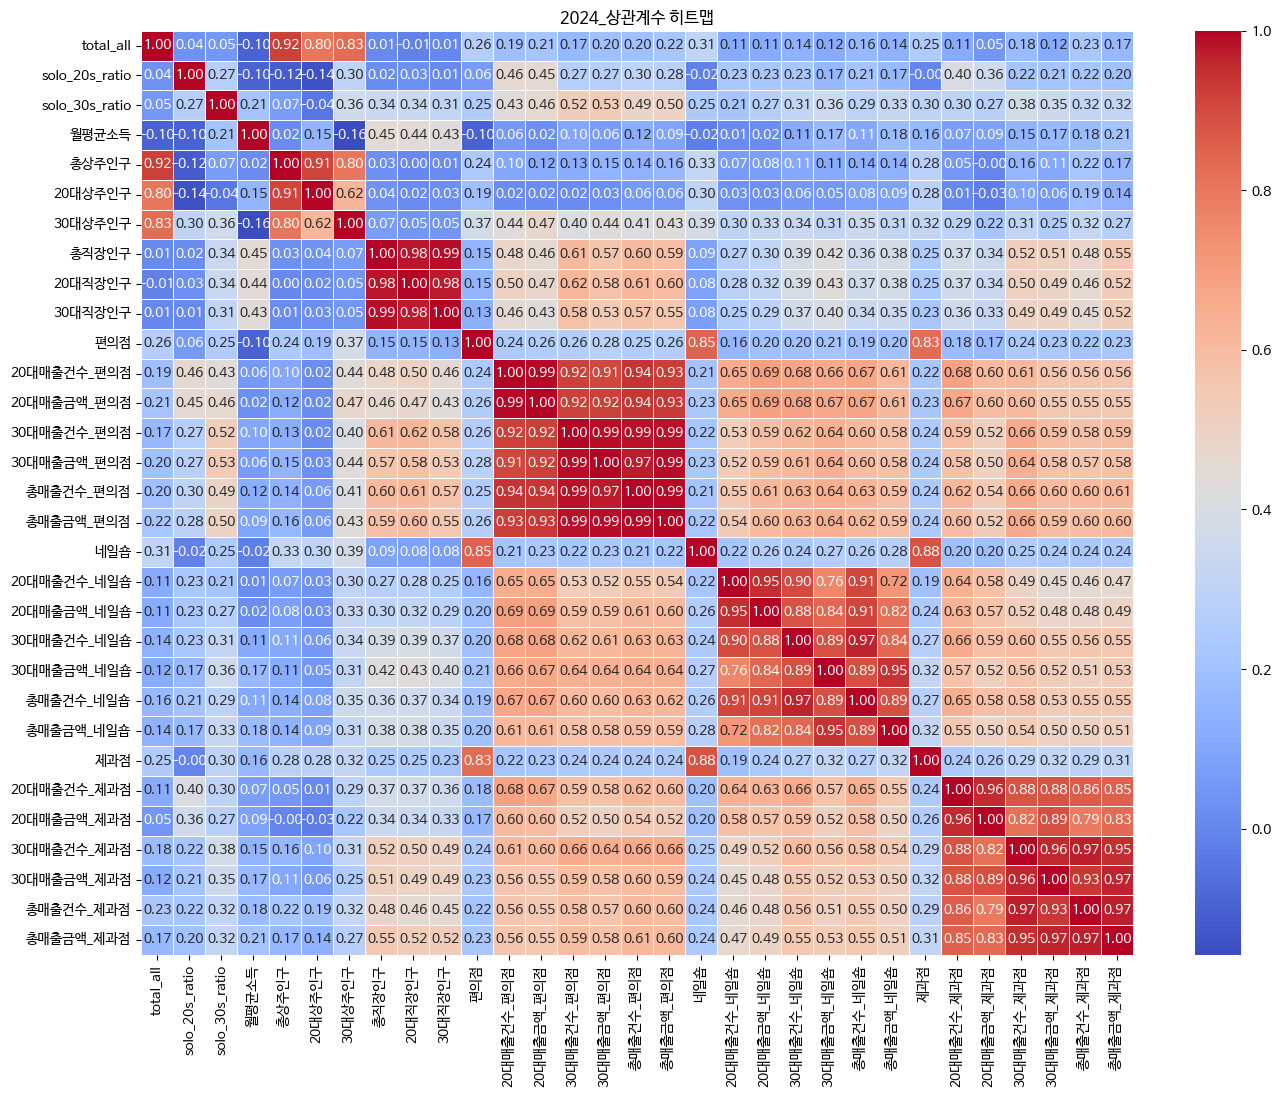

In [127]:
temp = df_selected.drop(columns = 'ADM_CD')
temp_corr = temp.corr(numeric_only = True)

# 히트맵 그리기
plt.figure(figsize=(16, 12))
sns.heatmap(temp_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title(f"{year}_상관계수 히트맵")
# plt.savefig(f'{final_img}/{year}_상관관계.png', format='png')
plt.show()

In [ ]:
### Outlier detection

Q1 = df_selected[['월평균소득', '총상주인구', '총직장인구']].quantile(0.25)
Q3 = df_selected[['월평균소득', '총상주인구', '총직장인구']].quantile(0.75)


IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers_mask = ((df_selected[['월평균소득', '총상주인구', '총직장인구']] < lower_bound) | (df_selected[['월평균소득', '총상주인구', '총직장인구']] > upper_bound)).any(axis=1)

cleaned_df_selected = df_selected[~outliers_mask]

In [145]:

## 합친 결과물
df_ols = pd.DataFrame()

df_list = ['df_2023', 'cleaned_df_selected']

for df in df_list:
    df_ols = pd.DataFrame()
    for idx, shop in enumerate(shop_list):
        reg_temp = globals()[df][dong_info + basic_info  + globals()[shop]]
        reg_temp.drop(columns = ['ADM_CD',  '총상주인구','총직장인구',
                                f'20대매출건수_{shopname_list[idx]}', f'20대매출금액_{shopname_list[idx]}', f'30대매출건수_{shopname_list[idx]}', f'30대매출금액_{shopname_list[idx]}', f'{shopname_list[idx]}'], inplace = True)

        std_scaler = StandardScaler()
        df_std = std_scaler.fit_transform(reg_temp)
        df_std = pd.DataFrame(df_std)
        df_std.columns = reg_temp.columns

        depend_list = [f'총매출금액_{shopname_list[idx]}', f'총매출건수_{shopname_list[idx]}']

        for depend in depend_list:
            X = sm.add_constant(df_std.drop(columns = depend_list))

            # Fit the OLS model
            model = sm.OLS(df_std[depend], X)
            result = model.fit()

            summary = result.summary()

            temp = summary.tables[1].as_csv()

            ols_result = pd.read_csv(StringIO(temp), skipinitialspace=True)
            ols_result.columns = ['var', 'coef', 'std', 't', 'p', 'confi25', 'conf97']
            ols_result = ols_result[['var', 'coef', 'p']]

            ols_result['p'] = ols_result['p'].apply(lambda x: '+' if x < 0.05 else ' ')
            ols_result['coef'] = ols_result['coef'].apply(lambda x: round(x, 3))
            ols_result.columns = [f'var', f'c_{shopname_list[idx]}_{depend}', f'p_{shopname_list[idx]}_{depend}']
            ols_result['var'] = ols_result['var'].str.strip()

            globals()[f'{shop}_{depend}'] = ols_result

            if (idx == 0) & (depend == f'총매출금액_{shopname_list[idx]}'):
                df_ols = ols_result
            else:
                df_ols = df_ols.merge(ols_result,
                                      how='left',
                                      on='var',
                                      suffixes=('_df', '_cleaned'))
    final = df_ols.copy()
    final.to_excel(f'{final_sang}/{df}_reg.xlsx', index = False)
    final.to_csv(f'{final_sang}/{df}_reg.csv', index = False)

In [141]:
df_ols

,var,c_편의점_총매출금액_편의점_df,p_편의점_총매출금액_편의점_df,c_편의점_총매출건수_편의점_df,p_편의점_총매출건수_편의점_df,c_네일숍_총매출금액_네일숍_df,p_네일숍_총매출금액_네일숍_df,c_네일숍_총매출건수_네일숍_df,p_네일숍_총매출건수_네일숍_df,c_제과점_총매출금액_제과점_df,...,c_편의점_총매출건수_편의점_cleaned,p_편의점_총매출건수_편의점_cleaned,c_네일숍_총매출금액_네일숍_cleaned,p_네일숍_총매출금액_네일숍_cleaned,c_네일숍_총매출건수_네일숍_cleaned,p_네일숍_총매출건수_네일숍_cleaned,c_제과점_총매출금액_제과점_cleaned,p_제과점_총매출금액_제과점_cleaned,c_제과점_총매출건수_제과점_cleaned,p_제과점_총매출건수_제과점_cleaned
0,const,0.000,,0.000,,0.000,,0.000,,-0.000,...,-0.000,,0.000,,0.000,,-0.000,,-0.000,
1,total_all,0.010,,-0.026,,-0.235,+,-0.257,+,-0.037,...,0.153,,-0.171,,-0.226,+,0.019,,0.081,
2,solo_20s_ratio,0.059,,0.102,+,-0.011,,0.015,,0.138,...,0.257,+,0.113,,0.100,,0.234,+,0.235,+
3,solo_30s_ratio,0.120,+,0.106,+,-0.014,,-0.083,,0.067,...,0.139,+,-0.010,,-0.129,,0.068,,0.079,
4,월평균소득,-0.073,,-0.053,,0.140,+,0.089,,0.010,...,-0.033,,0.034,,0.018,,-0.076,,-0.064,
5,20대상주인구,-0.202,+,-0.154,+,-0.113,,-0.146,,0.076,...,-0.193,+,-0.070,,-0.104,,0.201,+,0.201,+
6,30대상주인구,0.447,+,0.419,+,0.592,+,0.675,+,0.168,...,0.333,+,0.496,+,0.607,+,0.027,,0.031,
7,20대직장인구,1.057,+,1.018,+,0.661,+,0.633,+,0.139,...,0.169,,-0.016,,0.020,,-0.047,,0.025,
8,30대직장인구,-0.502,+,-0.449,+,-0.377,,-0.319,,0.351,...,0.023,,0.120,,0.102,,0.247,,0.159,


In [130]:
df_ols = pd.DataFrame()
for idx, shop in enumerate(shop_list):
    reg_temp = cleaned_df_selected [dong_info + basic_info  + globals()[shop]]
    reg_temp.drop(columns = ['ADM_CD', f'20대매출건수_{shopname_list[idx]}', f'20대매출금액_{shopname_list[idx]}', f'30대매출건수_{shopname_list[idx]}', f'30대매출금액_{shopname_list[idx]}', f'{shopname_list[idx]}'], inplace = True)

    std_scaler = StandardScaler()
    df_std = std_scaler.fit_transform(reg_temp)
    df_std = pd.DataFrame(df_std)
    df_std.columns = reg_temp.columns

    depend_list = [f'총매출금액_{shopname_list[idx]}', f'총매출건수_{shopname_list[idx]}']

    for depend in depend_list:
        X = sm.add_constant(df_std.drop(columns = depend_list))

        # Fit the OLS model
        model = sm.OLS(df_std[depend], X)
        result = model.fit()

        summary = result.summary()

        temp = summary.tables[1].as_csv()

        ols_result = pd.read_csv(StringIO(temp), skipinitialspace=True)
        ols_result.columns = ['var', 'coef', 'std', 't', 'p', 'confi25', 'conf97']
        ols_result = ols_result[['var', 'coef', 'p']]

        ols_result['p'] = ols_result['p'].apply(lambda x: '+' if x < 0.05 else ' ')
        ols_result['coef'] = ols_result['coef'].apply(lambda x: round(x, 3))
        ols_result.columns = [f'var', f'c_{shopname_list[idx]}_{depend}', f'p_{shopname_list[idx]}_{depend}']
        ols_result['var'] = ols_result['var'].str.strip()

        globals()[f'{shop}_{depend}'] = ols_result

        if (idx == 0) & (depend == f'총매출금액_{shopname_list[idx]}'):
            df_ols = ols_result
        else:
            df_ols = df_ols.merge(ols_result,
                                        how = 'left',
                                        on = 'var')

In [131]:
df_ols

,var,c_편의점_총매출금액_편의점,p_편의점_총매출금액_편의점,c_편의점_총매출건수_편의점,p_편의점_총매출건수_편의점,c_네일숍_총매출금액_네일숍,p_네일숍_총매출금액_네일숍,c_네일숍_총매출건수_네일숍,p_네일숍_총매출건수_네일숍,c_제과점_총매출금액_제과점,p_제과점_총매출금액_제과점,c_제과점_총매출건수_제과점,p_제과점_총매출건수_제과점
0,const,0.000,,-0.000,,0.000,,0.000,,-0.000,,-0.000,
1,total_all,0.323,+,0.300,+,-0.004,,0.049,,0.085,,0.144,
2,solo_20s_ratio,0.084,,0.160,+,0.000,,-0.081,,0.192,+,0.195,+
3,solo_30s_ratio,0.178,+,0.135,+,-0.012,,-0.137,+,0.064,,0.076,
4,월평균소득,-0.052,,-0.020,,0.053,,0.041,,-0.074,,-0.061,
5,총상주인구,-0.527,+,-0.558,+,-0.681,+,-1.030,+,-0.204,,-0.207,
6,20대상주인구,0.021,,0.059,,0.243,,0.358,+,0.288,+,0.291,+
7,30대상주인구,0.506,+,0.514,+,0.701,+,0.943,+,0.107,,0.107,
8,총직장인구,0.284,,0.252,,0.636,+,0.381,,-0.217,,-0.104,
9,20대직장인구,0.176,,0.144,,-0.093,,-0.015,,-0.012,,0.043,


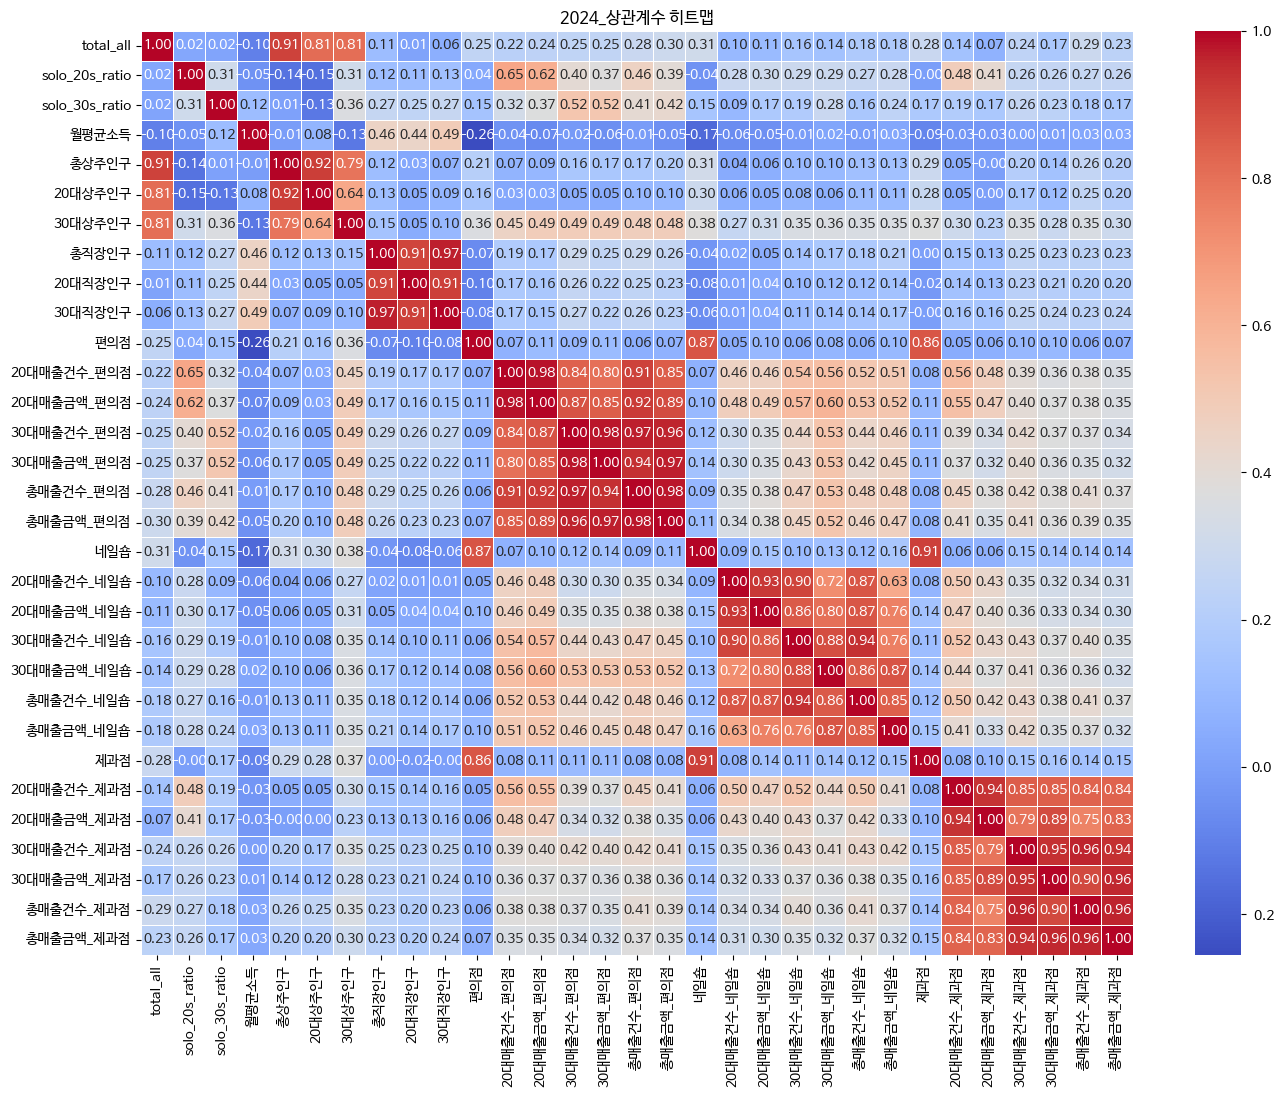

In [132]:
temp = cleaned_df_selected.drop(columns = 'ADM_CD')
temp_corr = temp.corr(numeric_only = True)

# 히트맵 그리기
plt.figure(figsize=(16, 12))
sns.heatmap(temp_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title(f"{year}_상관계수 히트맵")
# plt.savefig(f'{final_img}/{year}_상관관계.png', format='png')
plt.show()